In [1]:
%matplotlib inline

In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import pylab as P

import statsmodels.api as sm 

In [3]:
def read_data(file_name, has_header):
    f = open(file_name, 'r')
    if has_header:
        header = re.sub('["\n]', '', f.readline()).split(' ')
    matrix = []
    data = []
    for line in f:
        items = line.split(' ')
        if len(items) > 1:
            matrix.append(items[0])
            del items[0]
            data.append(list(map(float, items)))
    if has_header:
        return (matrix, np.asmatrix(data), header)
    else:
        return matix, np.asmatrix(data)

In [4]:
def plot_data(data, plot_type, header=None, cmap=None, xlim=None, ylim=None):
    if plot_type == "scatter":
        plt.scatter(data[:,0], data[:,1])
        if xlim is not None and ylim is not None:
            plt.xlim(xlim)
            plt.ylim(ylim)
        else:
            plt.axis('equal')
    if plot_type == "scatter_matrix":
        df = pd.DataFrame(data, columns=header)
        axes = scatter_matrix(df, alpha=0.2, figsize=(10, 10), diagonal='kde')
        equal_axes_scatter_matrix(axes, len(header))
    if plot_type == "color_map":
        plt.pcolor(data, cmap=cmap)
        plt.colorbar()
    if plot_type == "histogram":
        colors = ["g", "r", "b"]
        for i in range(data.shape[1]):
            n, bins, patches = P.hist(data[:,i], 50, normed=1, histtype='stepfilled')
            P.setp(patches, 'facecolor', colors[i], 'alpha', 0.75)
            plt.show()
    else:
        plt.show()

In [5]:
matrix, data, header = read_data("../stats/MatVecMultStats_949732.txt", True)

In [6]:
matrix, data, header = read_data("../stats/MatVecMultStats_976646.txt", True)

In [6]:
matrix, avg_data, header = read_data("../stats/MatVecFormatMemoryStats_713924.txt", True)

In [8]:
files = ["25615", "391750", "494030", "497461", "643522", "674742", "685203", "810763", "867607", "872897"]

In [42]:
avg_data = None
for f in files:
    matrix, data, header = read_data("../stats/MatVecMultStats_" + f + ".txt", True)
    if avg_data is None:
        avg_data = data
    else:
        avg_data = avg_data + data
avg_data = avg_data / len(files)

In [43]:
Y = avg_data

In [44]:
Y = avg_data / np.linalg.norm(data)

In [45]:
header2 = header
del header2[0]

In [46]:
df_Y = pd.DataFrame(Y, columns = header2)

In [47]:
avg_data[:,0].sum()

3850490.8999999999

In [48]:
avg_data.min(1).sum()

2538347.3000000003

In [49]:
avg_data[:,0].sum() / (avg_data.min(1).sum() + add_time.sum())

0.44731600065023319

In [50]:
indices = avg_data.argmin(1).A1

In [51]:
d = data[range(data.shape[0]),indices].A1
d[indices == 0] = 0

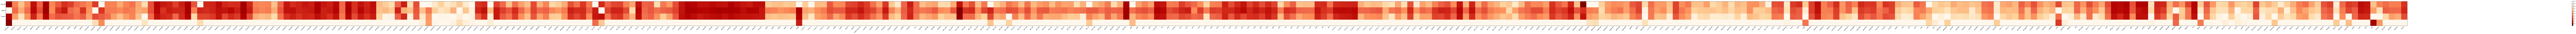

In [52]:
comparetomin = avg_data / avg_data.max(1)
fig = plt.figure(figsize = (400,3))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
ax.set_yticks([0,1,2])
ax.set_yticklabels(header[1:4])
ax.set_xticks([i for i in range(len(matrix))])
ax.set_xticklabels(matrix, rotation=45, ha="right")
plt.imshow(comparetomin.T, interpolation='nearest', cmap="OrRd_r")
plt.colorbar()
plt.show()

In [48]:
matrix, data, header = read_data("../stats/MatVecConvertStats_949732.txt", True)

In [49]:
matrix, data, header = read_data("../stats/MatVecConvertStats_976646.txt", True)

In [53]:
avg_data = None
for f in files:
    matrix, data, header = read_data("../stats/MatVecConvertStats_" + f + ".txt", True)
    if avg_data is None:
        avg_data = data
    else:
        avg_data = avg_data + data
avg_data = avg_data / len(files)

In [54]:
add_time = avg_data[range(avg_data.shape[0]), indices-1].A1
add_time[indices == 0] = 0
add_time.sum()

6069641.0

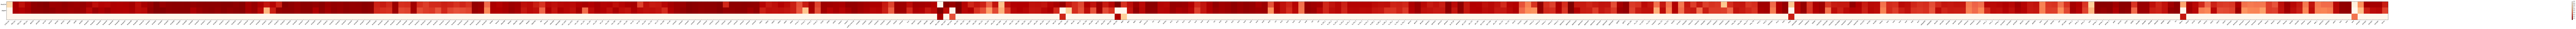

In [55]:
comparetomin = data / data.max(1)
fig = plt.figure(figsize = (400,2))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
ax.set_yticks([0,1])
ax.set_yticklabels(header[1:3])
ax.set_xticks([i for i in range(len(matrix))])
ax.set_xticklabels(matrix, rotation=45, ha="right")
plt.imshow(comparetomin.T, interpolation='nearest', cmap="OrRd_r")
plt.colorbar()
plt.show()

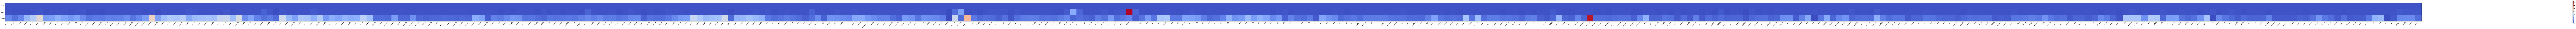

In [23]:
comparetomin = data[1:data.shape[0],:] / data[1:data.shape[0],0]
fig = plt.figure(figsize = (400,3))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
ax.set_yticks([0,1,2])
ax.set_yticklabels(header[1:4])
ax.set_xticks([i for i in range(len(matrix))])
ax.set_xticklabels(matrix, rotation=45, ha="right")
plt.imshow(comparetomin.T, interpolation='nearest', cmap="coolwarm")
plt.colorbar()
plt.show()

In [24]:
matrix, data, header = read_data("../stats/MtxStats_76951.txt", True)

IOError: [Errno 2] No such file or directory: '../stats/MtxStats_76951.txt'

In [ ]:
matrix, data, header = read_data("../stats/MtxStats_976646.txt", True)

In [25]:
avg_data = None
for f in files:
    matrix, data, header = read_data("../stats/MtxStats_" + f + ".txt", True)
    if avg_data is None:
        avg_data = data
    else:
        avg_data = avg_data + data
avg_data = avg_data / len(files)

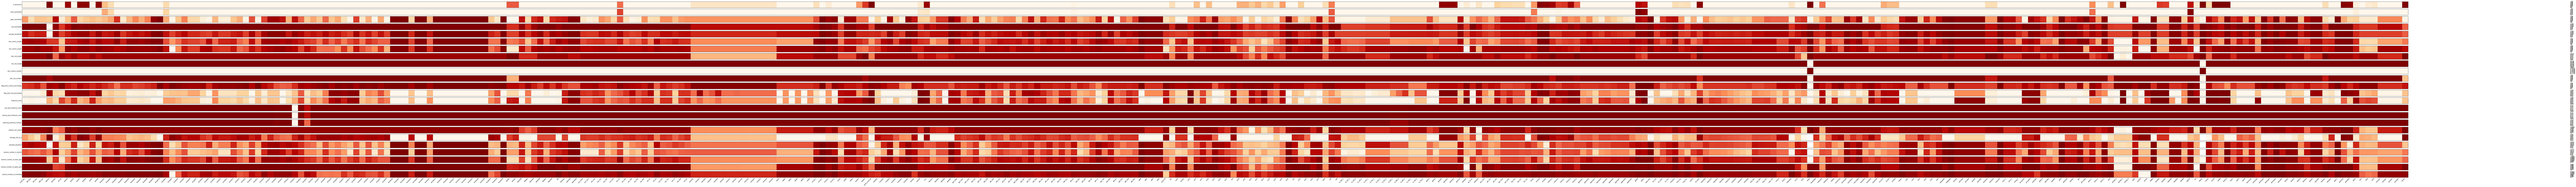

In [26]:
scaled_data = avg_data.T#(data[:,1:24] / data[:,0]).T
fig = plt.figure(figsize = (444,24))
for i in range(0, 24, 1):
    ax = plt.subplot(24, 1, i+1)
    ax.set_yticks([0])
    ax.set_yticklabels([header[i+1]])
    if i == 23:
        ax.set_xticks(range(len(matrix)))
        ax.set_xticklabels(matrix, rotation=45, ha="right")
    else:
        ax.get_xaxis().set_visible(False) 
    plt.imshow(scaled_data[i-1,:], interpolation='nearest', cmap="OrRd_r")
    plt.colorbar()

plt.show()

In [33]:
X = sm.add_constant(avg_data)

In [34]:
norm_x = np.ones_like(avg_data)

for i in range(avg_data.shape[1]):
    norm_x[:, i] = avg_data[:, i] / np.linalg.norm(avg_data[:, i])

X = sm.add_constant(norm_x)

In [35]:
header2 = header
header2[0] = "const"
df_X = pd.DataFrame(X, columns = header2)

In [36]:
del df_X[header2[20]]
del df_X[header2[19]]
del df_X[header2[18]]
del df_X[header2[9]]

In [37]:
X = np.delete(X, 20, axis=1)
X = np.delete(X, 19, axis=1)
X = np.delete(X, 18, axis=1)
X = np.delete(X, 9, axis=1)
X.shape

(389, 21)

In [38]:
model = sm.OLS(df_Y['CSR'], df_X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                    CSR   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     2.123
Date:                Tue, 08 Sep 2015   Prob (F-statistic):            0.00356
Time:                        14:46:43   Log-Likelihood:                 1171.4
No. Observations:                 389   AIC:                            -2301.
Df Residuals:                     368   BIC:                            -2218.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const           

In [39]:
model = sm.OLS(df_Y['ModCSR'], df_X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                 ModCSR   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.3548
Date:                Tue, 08 Sep 2015   Prob (F-statistic):              0.996
Time:                        14:47:28   Log-Likelihood:                 807.46
No. Observations:                 389   AIC:                            -1573.
Df Residuals:                     368   BIC:                            -1490.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const           

In [40]:
model = sm.OLS(df_Y['Jagged'], df_X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                 Jagged   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.957
Date:                Tue, 08 Sep 2015   Prob (F-statistic):            0.00863
Time:                        14:47:28   Log-Likelihood:                 1004.0
No. Observations:                 389   AIC:                            -1966.
Df Residuals:                     368   BIC:                            -1883.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const           

In [41]:
model = sm.OLS(df_Y['Ellpack'], df_X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                Ellpack   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.712
Date:                Tue, 08 Sep 2015   Prob (F-statistic):             0.0295
Time:                        14:47:29   Log-Likelihood:                 1025.1
No. Observations:                 389   AIC:                            -2008.
Df Residuals:                     368   BIC:                            -1925.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const           